# FCNN Autoencoder

In [38]:
from keras.layers import Input, Dense#, Dropout, BatchNormalization, Reshape
from keras.models import Model
#from keras.regularizers import l2
from keras.utils import plot_model
from keras.callbacks import EarlyStopping

import pickle
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [39]:
# load the pickle file
PATH = '../'

with open(PATH+'means_array.p', 'rb') as infile:
    means_array = pickle.load(infile)
    
n_frame = means_array.shape[1]
n_total = means_array.shape[0]

data = means_array[:,:,:2]
data.shape

(83, 179, 2)

## Data preparation

In [144]:
n_train = 82
n_test = n_total - n_train

#x_train, x_test = data[:n_train,:,1], data[n_train:,:,1]
x_train, x_validation, x_test = data[:70,:,1], data[70:81,:,1], data[81:82,:,1] 

x_train = x_train / 300 #- np.mean(x_train))/ np.std(x_train)**2
x_validation = x_validation/ 300 # - np.mean(x_test))/ np.std(x_test)**2
x_test = x_test/ 300 # - np.mean(x_test))/ np.std(x_test)**2

#x_train = x_train.reshape((n_train, n_frame))
#x_test = x_test.reshape((n_test, n_frame))
print('train', x_train.shape)
print('validation', x_validation.shape)
print('test', x_test.shape)

train (70, 179)
validation (11, 179)
test (1, 179)


In [145]:
def split_data(x_test, fact):
    if fact > 1:
        return "fact must be lower than 1"
    x_test_ = []
    x_test_.append(np.array([x_test[i,0:int(x_test.shape[1]*fact + 1)] for i in range(0, x_test.shape[0])]))
    for j in range(1, int(fact**-1)):
        x_test_.append(np.array([x_test[i,int(x_test.shape[1]*j*fact):int(x_test.shape[1]*(j+1)*fact)]
                             for i in range(0, x_test.shape[0])]))
      
    return np.concatenate((x_test_), axis=0)

In [146]:
def split_data(x_test, fact):
    if fact > 1:
        return "fact must be lower than 1"
    x_test_ = []
    x_test_.append(np.array([x_test[i,0:int(x_test.shape[1]*fact + 1)] for i in range(0, x_test.shape[0])]))
    for j in range(1, int(fact**-1)):
        x_test_.append(np.array([x_test[i,int(x_test.shape[1]*j*fact):int(x_test.shape[1]*(j+1)*fact)]
                             for i in range(0, x_test.shape[0])]))
      
    return np.concatenate((x_test_), axis=0)

In [147]:
windows = 5

In [148]:
x_train = split_data(x_train, windows**-1)
x_validation = split_data(x_validation, windows**-1)
x_test = split_data(x_test, windows**-1)

print(x_train.shape)
print(x_validation.shape)
print(x_test.shape)

(350, 36)
(55, 36)
(5, 36)


## Architecture Definition

In [149]:
# -- FFNN ARCHITECTURE --

input_seq = Input(shape=(int(x_train.shape[1]),))
X = Dense(12, activation='tanh')(input_seq)
# "encoded" is the encoded representation of the input
encoded = Dense(6, activation='tanh')(X)
X = Dense(12, activation='tanh')(encoded)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(int(x_train.shape[1]), activation='tanh')(X) #, activity_regularizer=l2(0.001)

# This model maps an input to its reconstruction (hopefully denoised)
autoencoder = Model(input_seq, decoded)
autoencoder.compile(optimizer='adam', loss= "mean_absolute_error")

In [150]:
autoencoder.summary()
plot_model(autoencoder, show_shapes=True, to_file='FFNN.png', rankdir='LR', show_layer_names=False) #TB o LR

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 36)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 12)                444       
_________________________________________________________________
dense_30 (Dense)             (None, 6)                 78        
_________________________________________________________________
dense_31 (Dense)             (None, 12)                84        
_________________________________________________________________
dense_32 (Dense)             (None, 36)                468       
Total params: 1,074
Trainable params: 1,074
Non-trainable params: 0
_________________________________________________________________


## Model Training

In [151]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history = autoencoder.fit(x_train, x_train,
                epochs=150,
                steps_per_epoch=100,
                shuffle=True,
                batch_size=None,
                validation_data=(x_validation, x_validation), 
                validation_steps = 1,
                callbacks=[es]
               )

Train on 350 samples, validate on 55 samples
Epoch 1/150
100/100 [==============================] - 2s 17ms/step - loss: 0.1833 - val_loss: 0.0680
Epoch 2/150
100/100 [==============================] - 0s 3ms/step - loss: 0.0430 - val_loss: 0.0340
Epoch 3/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0304 - val_loss: 0.0288
Epoch 4/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0259 - val_loss: 0.0241
Epoch 5/150
100/100 [==============================] - 0s 3ms/step - loss: 0.0223 - val_loss: 0.0215
Epoch 6/150
100/100 [==============================] - 0s 3ms/step - loss: 0.0207 - val_loss: 0.0204
Epoch 7/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0200 - val_loss: 0.0199
Epoch 8/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0196 - val_loss: 0.0195
Epoch 9/150
100/100 [==============================] - 0s 3ms/step - loss: 0.0193 - val_loss: 0.0192
Epoch 10/150
100/100 [=======================

Epoch 81/150
100/100 [==============================] - 0s 3ms/step - loss: 0.0146 - val_loss: 0.0148
Epoch 82/150
100/100 [==============================] - 0s 3ms/step - loss: 0.0146 - val_loss: 0.0148
Epoch 83/150
100/100 [==============================] - 0s 3ms/step - loss: 0.0146 - val_loss: 0.0148
Epoch 84/150
100/100 [==============================] - 0s 4ms/step - loss: 0.0145 - val_loss: 0.0148
Epoch 85/150
100/100 [==============================] - 0s 3ms/step - loss: 0.0145 - val_loss: 0.0148
Epoch 00085: early stopping


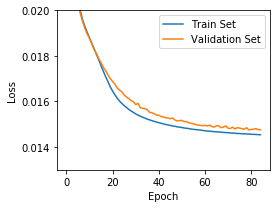

In [152]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_ylim((0.013,0.02))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Set', 'Validation Set'], loc='upper right')
plt.tight_layout()
plt.show()
#plt.savefig('history.png')

## Prediction on Test Set

fig 1


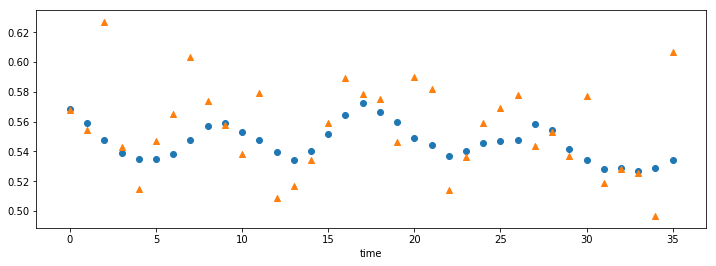

fig 2


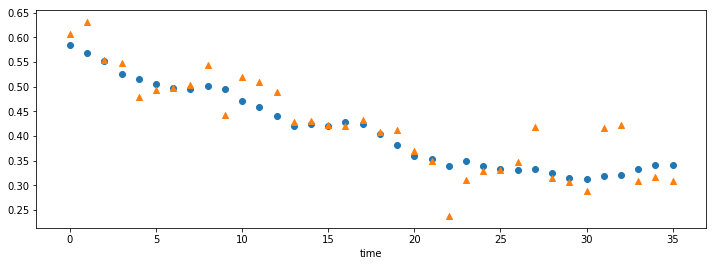

fig 3


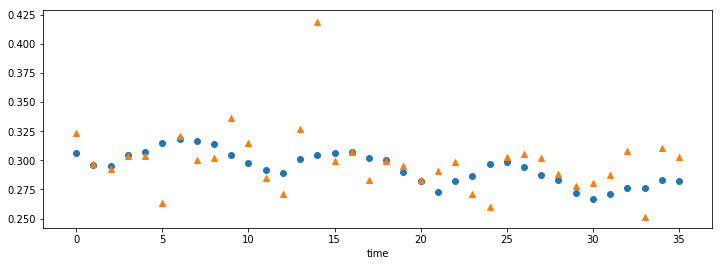

fig 4


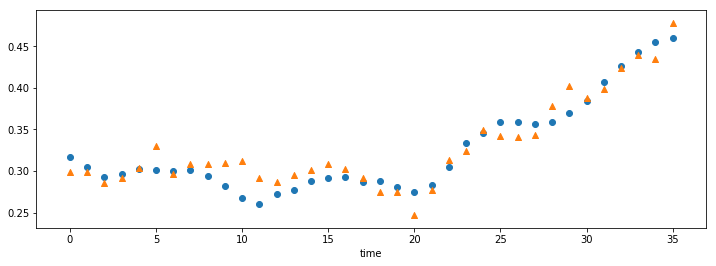

fig 5


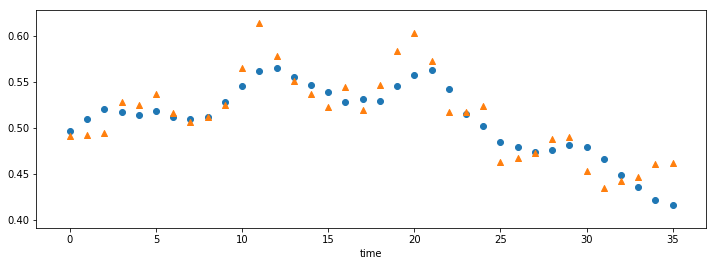

In [153]:
for i_predict in range(int(x_test.shape[0])):
    x_predict = autoencoder.predict(x_test[i_predict,:].reshape((1,x_train.shape[1])))

    print("fig {}".format(i_predict +1))
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(111)
    plt.ylabel(''); plt.xlabel('time')
    ax.scatter(range(x_train.shape[1],), x_predict, marker='o')
    ax.scatter(range(x_train.shape[1],), x_test[i_predict, :], marker='^')
    
    plt.show()

## Windows Merging

In [154]:
def comeback_to_data(x_test, fact):
    if fact > 1:
        return "fact must be lower than 1"
    x_test_ = []
    x_test_.append(np.array([x_test[i,:-1] for i in range(0, int(x_test.shape[0]/windows))]))
    for j in range(1, int(fact**-1)):
        x_test_.append(np.array([x_test[i,:] for i in range(int(x_test.shape[0]*j*fact), int(x_test.shape[0]*(j+1)*fact))]))
      
    return np.concatenate((x_test_), axis=1)

In [155]:
x_predict = []
for i_predict in range(x_test.shape[0]):
    x_predict.append(autoencoder.predict(x_test[i_predict,:].reshape((1,x_train.shape[1]))))

x_predict = np.concatenate((x_predict), axis = 0)

x_predict = comeback_to_data(x_predict, windows**-1)
print(x_predict.shape)

(1, 179)


In [156]:
x_train = comeback_to_data(x_train, windows**-1)
x_test = comeback_to_data(x_test, windows**-1)
print(x_train.shape); print(x_test.shape)

(70, 179)
(1, 179)


## Final Denoised Series

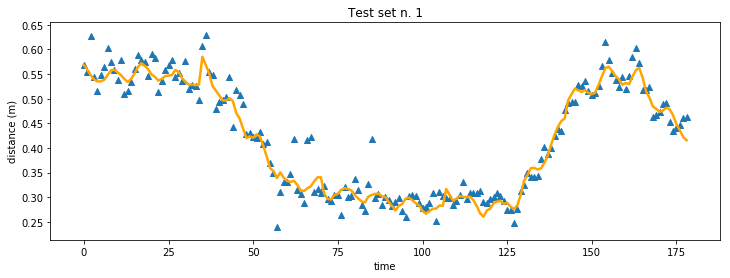

In [157]:
for j in range(x_test.shape[0]):
    dim = (0, 1)
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(111)
    plt.ylabel(''); plt.xlabel('time')
    #plt.ylim(dim)
    #ax.scatter(range(x_train.shape[1],), x_predict[j,:], marker='o')
    ax.plot(x_predict[j,:], linewidth = 2.5, c='orange')
    ax.scatter(range(x_train.shape[1],), x_test[j,:], marker='^')
    ax.set_ylabel("distance (m)")
    plt.title("Test set n. {}".format(j+1))